# **Data Pre-Processing**

In [ ]:
from google.colab import files


uploaded = files.upload()

'\nfrom google.colab import files\n\n\nuploaded = files.upload()\n'

In [ ]:
import pandas as pd
df = pd.read_csv("Arxiv Resources.csv")

In [ ]:
df.columns

Index(['Title', 'Abstract', 'authors', 'Year', 'URL', 'Source'], dtype='object')

In [ ]:
df.head()

,Title,Abstract,authors,Year,URL,Source
0,The Governance of Physical Artificial Intellig...,Physical artificial intelligence can prove to ...,"Yingbo Li, Anamaria-Beatrice Spulber, Yucong Duan",2023,http://arxiv.org/abs/2304.02924v1,Arxive
1,Does an artificial intelligence perform market...,Who should be charged with responsibility for ...,Takanobu Mizuta,2020,http://arxiv.org/abs/2005.10488v1,Arxive
2,Impact of Artificial Intelligence on Economic ...,Artificial intelligence has impacted many aspe...,Tshilidzi Marwala,2015,http://arxiv.org/abs/1509.01213v1,Arxive
3,The case for psychometric artificial general i...,A short review of the literature on measuremen...,Mark McPherson,2020,http://arxiv.org/abs/2101.02179v1,Arxive
4,AAAI FSS-18: Artificial Intelligence in Govern...,Proceedings of the AAAI Fall Symposium on Arti...,"Frank Stein, Alun Preece, Mihai Boicu",2018,http://arxiv.org/abs/1810.06018v1,Arxive


In [ ]:
# Determine the best text column to use
text_column = "Abstract" if "Abstract" in df.columns else "Title"
text_column

'Abstract'

In [ ]:
df["Abstract"] = df["Abstract"].fillna(df["Title"])

In [ ]:
df.shape

(4657, 6)

# **Text Embedding Using Bert**

In [ ]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# **Run The Saved Embedding and Latent File From Google Drive**
If it's your first time running the program, skip this part

In [123]:
# Mount Google Drive
from google.colab import drive
#drive.mount('/content/drive')

# Load the saved NumPy arrays
import numpy as np

embeddings = np.load("embeddings.npy")
reduced_embeddings = np.load("reduced_embeddings.npy")

#check the shape
print("Embeddings shape:", embeddings.shape)
print("Reduced embeddings shape:", reduced_embeddings.shape)


Embeddings shape: (4657, 384)
Reduced embeddings shape: (4657, 64)


In [124]:
'''
import re
# FIRST VERSION
# Preprocess text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df[text_column] = df[text_column].fillna("").apply(clean_text)

# Generate embeddings efficiently
print("Generating text embeddings...")
embeddings = model.encode(df[text_column].tolist(), batch_size=128, show_progress_bar=True)
'''

'\nimport re\n# FIRST VERSION\n# Preprocess text\ndef clean_text(text):\n    if isinstance(text, str):\n        text = text.lower()\n        text = re.sub(r\'\\d+\', \'\', text)  # Remove numbers\n        text = re.sub(r\'[^\\w\\s]\', \'\', text)  # Remove punctuation\n        text = text.strip()  # Remove extra spaces\n    return text\n\n# Apply preprocessing\ndf[text_column] = df[text_column].fillna("").apply(clean_text)\n\n# Generate embeddings efficiently\nprint("Generating text embeddings...")\nembeddings = model.encode(df[text_column].tolist(), batch_size=128, show_progress_bar=True)\n'

In [125]:
embeddings.shape

(4657, 384)

In [126]:
import spacy
import pandas as pd

# Load English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_with_spacy(text):
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

df['lemmatized_text'] = df[text_column].apply(lemmatize_with_spacy)



In [ ]:
import re
# SECOND VERSION
# Preprocess text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df[text_column] = df['lemmatized_text'].fillna("").apply(clean_text)

# Generate embeddings efficiently
print("Generating text embeddings...")
embeddings = model.encode(df[text_column].tolist(), batch_size=128, show_progress_bar=True)

Generating text embeddings...


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

# **Dimantiality Reduction Using Autoencoder**
We use an autoencoder neural network to perform unsupervised dimensionality reduction and anomaly detection on high-dimensional embeddings.The autoencoder learns to compress each embedding into a lower-dimensional latent representation (via the bottleneck layer) and then reconstruct it back to its original form. By minimizing the reconstruction error during training, the model captures the most important features of the data. Once trained, each document's reconstruction error is computed, and those with the highest errors (the top 5%) are identified as poorly reconstructed samples which may represent outliers, unusual structure, or noise.

The goal is to detect and optionally filter out samples that deviate significantly from the learned structure of the dataset. This improves the quality of downstream tasks in this project inclusing clustering, semantic search, or topic modeling by reducing the influence of noisy or inconsistent data. The benefits include cleaner datasets, better-defined clusters, and the ability to identify edge cases or rare patterns.

In [ ]:
df[text_column][3]

'a short review of the literature on measurement and detection of artificial \n general intelligence be make propose benchmark and test for artificial \n general intelligence be critically evaluate against multiple criterion base \n on the finding the most promising approach be identify and some useful \n direction for future work be propose'

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.9731e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6966e-04
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4097e-04
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2892e-04
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2004e-04
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0002e-04
Epoch 12/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8527e-04
Epoch 13/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8448e-04
Epoch 14/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7579e-04
Epoch 15/50
146/146 ━

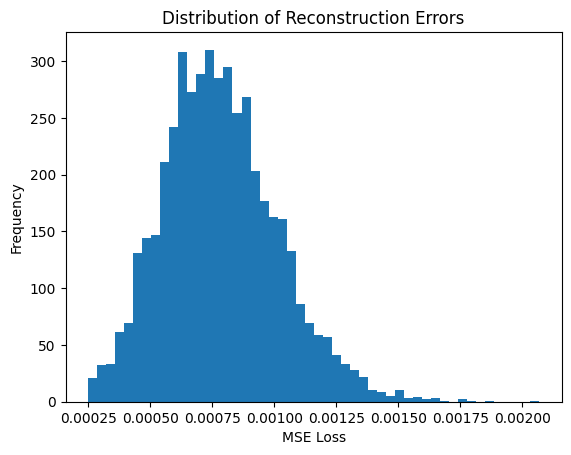

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the autoencoder architecture
input_dim = embeddings.shape[1]  # Input size equals the dimension of embeddings

input_layer = Input(shape=(input_dim,))  # Input layer
encoded = Dense(128, activation='relu')(input_layer)  # First encoding layer
encoded = Dense(64, activation='relu')(encoded)       # Bottleneck layer (compressed representation)
decoded = Dense(128, activation='relu')(encoded)      # First decoding layer
decoded = Dense(input_dim, activation='linear')(decoded)  # Output layer (reconstruct original input)

autoencoder = Model(inputs=input_layer, outputs=decoded)  # Full autoencoder model
encoder = Model(inputs=input_layer, outputs=encoded)      # Encoder model (for dimensionality reduction)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Compile with MSE loss

# Train the autoencoder to reconstruct input embeddings
autoencoder.fit(embeddings, embeddings, epochs=50, batch_size=32, shuffle=True)

# Get reduced (encoded) and reconstructed embeddings
reduced_embeddings = encoder.predict(embeddings)              # Compressed version
reconstructed_embeddings = autoencoder.predict(embeddings)    # Output from autoencoder

# Compute reconstruction error (MSE) for each sample
reconstruction_errors = np.mean((embeddings - reconstructed_embeddings) ** 2, axis=1)

# Identify samples with reconstruction error above the 95th percentile
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% error threshold
poorly_reconstructed_indices = np.where(reconstruction_errors > threshold)[0]  # Indices of poor samples

print(f"\nNumber of poorly reconstructed samples: {len(poorly_reconstructed_indices)}")

# Plot histogram of reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("MSE Loss")
plt.ylabel("Frequency")
plt.show()


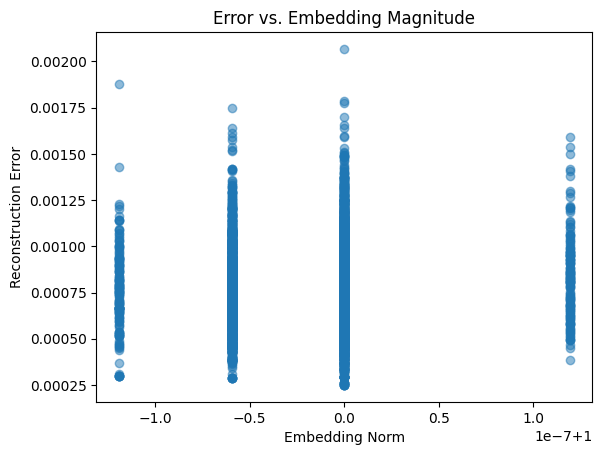

In [ ]:
norms = np.linalg.norm(embeddings, axis=1)
plt.scatter(norms, reconstruction_errors, alpha=0.5)
plt.xlabel("Embedding Norm")
plt.ylabel("Reconstruction Error")
plt.title("Error vs. Embedding Magnitude")
plt.show()


In [ ]:
reduced_embeddings.shape

(4657, 64)

# **Find The Best Number Of Components For GMM Based On silhouette Score**

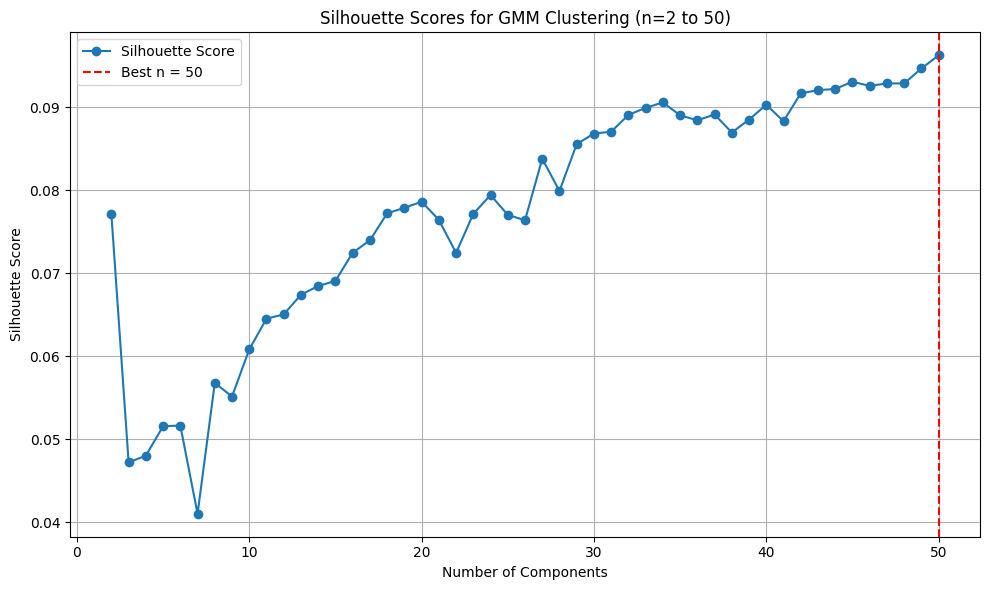

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

sil_scores = []  # List to store silhouette scores for each n
components_range = list(range(2, 51))  # Range of GMM components

# Try different numbers of GMM components (clusters) from 2 to 50
for n in components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    labels = gmm.fit_predict(reduced_embeddings)
    sil = silhouette_score(reduced_embeddings, labels)
    sil_scores.append(sil)

best_n = components_range[np.argmax(sil_scores)]

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(components_range, sil_scores, marker='o', linestyle='-', label='Silhouette Score')
plt.axvline(x=best_n, color='red', linestyle='--', label=f'Best n = {best_n}')
plt.title('Silhouette Scores for GMM Clustering (n=2 to 50)')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_n

50

In [127]:
# Will use best_n = 20

best_n = 8

# **Keywords Extraction**

This method combines Gaussian Mixture Model clustering with TF-IDF-based keyword extraction to uncover the main themes within a corpus of text data. First, documents are embedded and reduced (using BERT + autoencoder), and then clustered into semantically coherent groups using GMM. After clustering, a TfidfVectorizer is applied to the original text to identify the most representative terms for each cluster. By averaging TF-IDF scores within each group, the top keywords are extracted—offering interpretable insights into the semantic focus of each cluster. The goal is to automatically group and summarize documents by topic without manual labeling.

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit Gaussian Mixture Model on the reduced embeddings
gmm = GaussianMixture(n_components=best_n, random_state=42)
gmm_labels = gmm.fit_predict(reduced_embeddings)

# Assign cluster labels to the DataFrame
df["Cluster"] = gmm_labels

# Initialize TF-IDF vectorizer (ignoring common English stopwords and limiting features to 2000)
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

# Transform the original text data into a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(df[text_column])

# Get the list of feature names (The words in the TF-IDF vocab)
terms = vectorizer.get_feature_names_out()

top_n = 10  # Number of top keywords to extract per cluster
cluster_keywords = {}

# Loop over each cluster to find top keywords
for cluster_num in sorted(df["Cluster"].unique()):
    # Get the indices of documents in the current cluster
    cluster_indices = df[df["Cluster"] == cluster_num].index.to_list()

    # Compute the mean TF-IDF score for each word across all docs in the cluster
    cluster_tfidf = X_tfidf[cluster_indices].mean(axis=0)

    # Convert sparse matrix to a flat NumPy array
    cluster_array = np.squeeze(np.asarray(cluster_tfidf))

    # Get indices of the top n highest scoring words
    top_term_indices = cluster_array.argsort()[::-1][:top_n]

    # Retrieve the actual words corresponding to those indices
    keywords = [terms[i] for i in top_term_indices]

    # Store the keywords for this cluster
    cluster_keywords[cluster_num] = keywords

# Print the top keywords for each cluster
for cluster, keywords in cluster_keywords.items():
    print(f"\n🔹Cluster {cluster} — Top Keywords:")
    print(", ".join(keywords))



🔹Cluster 0 — Top Keywords:
tree, ensemble, model, machine, decision, boost, learning, use, regression, algorithm

🔹Cluster 1 — Top Keywords:
learning, learn, reinforcement, metalearning, continual, task, algorithm, online, deep, representation

🔹Cluster 2 — Top Keywords:
model, network, neural, language, deep, learning, architecture, use, task, learn

🔹Cluster 3 — Top Keywords:
regression, algorithm, quantum, lasso, logistic, pca, ridge, linear, method, model

🔹Cluster 4 — Top Keywords:
ai, safety, ethical, ethic, intelligence, artificial, governance, bias, human, healthcare

🔹Cluster 5 — Top Keywords:
cluster, clustering, algorithm, datum, graph, method, learning, representation, tsne, learn

🔹Cluster 6 — Top Keywords:
privacy, fairness, federate, learning, model, datum, machine, fair, learn, differential

🔹Cluster 7 — Top Keywords:
topic, anomaly, model, detection, classification, ordinal, causal, use, method, datum


In [129]:
# Count how many non-zero TF-IDF terms each cluster has
for cluster_num in sorted(df["Cluster"].unique()):
    cluster_indices = df[df["Cluster"] == cluster_num].index.to_list()
    cluster_tfidf = X_tfidf[cluster_indices].mean(axis=0)
    cluster_array = np.squeeze(np.asarray(cluster_tfidf))

    nonzero_count = np.count_nonzero(cluster_array)
    print(f"🔹 Cluster {cluster_num} has {nonzero_count} non-zero TF-IDF keywords.")


🔹 Cluster 0 has 1823 non-zero TF-IDF keywords.
🔹 Cluster 1 has 1541 non-zero TF-IDF keywords.
🔹 Cluster 2 has 1956 non-zero TF-IDF keywords.
🔹 Cluster 3 has 1642 non-zero TF-IDF keywords.
🔹 Cluster 4 has 1700 non-zero TF-IDF keywords.
🔹 Cluster 5 has 1734 non-zero TF-IDF keywords.
🔹 Cluster 6 has 1604 non-zero TF-IDF keywords.
🔹 Cluster 7 has 1892 non-zero TF-IDF keywords.


# **Implementatiom**

The following method combines semantic embeddings, dimensionality reduction, and hierarchical clustering to retrieve relevant documents based on a user's query. First, each document is encoded using a Sentence-BERT model to capture deep semantic meaning. These high-dimensional embeddings are then compressed using an autoencoder, which reduces noise and preserves core structure. A Gaussian Mixture Model is applied to the reduced embeddings to group documents into high-level semantic clusters. When a user submits a query, it undergoes the same encoding and reduction process, is assigned to a cluster, and is compared to the cluster's documents using cosine similarity. A second layer of GMM clustering is then applied to document titles to refine the results even further, ensuring that the final recommendations are both thematically and topically relevant.



In [130]:
from sklearn.metrics.pairwise import cosine_similarity

df["Embeddings"] = list(embeddings)  # Assign precomputed embeddings to the DataFrame

# First-level clustering using reduced embeddings from the autoencoder
gmm = GaussianMixture(n_components=best_n, random_state=42)
df["Cluster"] = gmm.fit_predict(reduced_embeddings)  # Assign GMM cluster labels to DataFrame

def search_similar_resources(query, df, top_n=10, min_similarity=0.50, title_cluster_k=3):
    if not query.strip():  # Check for empty query
        print("Query is empty. Please enter valid keywords.")
        return pd.DataFrame()

    # Encode and reduce query using the trained SentenceTransformer and autoencoder
    query_embedding = model.encode([query])  # Convert query to embedding
    query_embedding_reduced = encoder.predict(query_embedding)  # Reduce embedding using autoencoder

    # Predict which cluster the query belongs to using the GMM
    query_cluster = gmm.predict(query_embedding_reduced)[0]
    cluster_df = df[df["Cluster"] == query_cluster].copy()  # Filter samples in the same cluster

    if cluster_df.empty:  # No samples found in the same cluster
        print("No relevant resources found in the identified cluster.")
        return pd.DataFrame()

    # Compute cosine similarity between query and cluster embeddings
    cluster_embeddings = np.vstack(cluster_df["Embeddings"].values)  # Stack embeddings for similarity calc
    similarity_scores = cosine_similarity(query_embedding, cluster_embeddings).flatten()  # Get similarity scores
    cluster_df["Similarity"] = similarity_scores  # Add similarity to DataFrame
    cluster_df = cluster_df[cluster_df["Similarity"] >= min_similarity]  # Filter by min similarity threshold

    if cluster_df.empty:  # No results meet similarity threshold
        print("No resources met the minimum similarity threshold.")
        return pd.DataFrame()

    # Title-level clustering: group similar titles within the filtered cluster
    title_embeddings = model.encode(cluster_df["Title"].tolist())  # Encode all titles
    if len(title_embeddings) < title_cluster_k:
        title_cluster_k = max(1, len(title_embeddings))  # Avoid GMM crash with too few samples

    title_gmm = GaussianMixture(n_components=title_cluster_k, random_state=42)  # Title GMM clustering
    cluster_df["TitleCluster"] = title_gmm.fit_predict(title_embeddings)  # Assign title cluster

    # Predict which title sub-cluster the query belongs to
    query_title_embedding = model.encode([query])  # Re-encode query for title space
    query_title_cluster = title_gmm.predict(query_title_embedding)[0]
    subcluster_df = cluster_df[cluster_df["TitleCluster"] == query_title_cluster].copy()  # Filter by title cluster

    if subcluster_df.empty:  # No titles in subcluster
        print("No relevant titles found in the identified subcluster.")
        return pd.DataFrame()

    # Drop duplicates based on Title and Similarity
    subcluster_df = subcluster_df.drop_duplicates(subset=["Title", "Similarity"])

    # Sort by similarity and return top N results
    top_results = subcluster_df.sort_values(by="Similarity", ascending=False).head(top_n)
    return top_results[["Title", "URL", "Similarity"]]  # Return relevant columns

# User Interaction
query = input("Enter keywords to search: ")  # User provides a search query
recommendations = search_similar_resources(query, df, top_n=10, min_similarity=0.50, title_cluster_k=3)  # Run search


Enter keywords to search: pca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


# **Print Out The Recommended Results**

In [131]:
from IPython.core.display import display, Markdown

def display_results_as_markdown(results):
    """
    Display search results as Markdown in Jupyter Notebook.
    """
    output = "### 🔍 Search Results:\n"
    for index, row in recommendations.iterrows():
        output += f"- **Title:** [{row['Title']}]({row['URL']})\n"
        output += f"  - ⭐ **Similarity Score:** {row['Similarity']:.2f}\n\n"
    display(Markdown(output))

# Call function
display_results_as_markdown(recommendations)


### 🔍 Search Results:
- **Title:** [Principal Component Analysis: A Natural Approach to Data Exploration](http://arxiv.org/abs/1804.02502v2)
  - ⭐ **Similarity Score:** 0.67

- **Title:** [FAST-PCA: A Fast and Exact Algorithm for Distributed Principal Component
  Analysis](http://arxiv.org/abs/2108.12373v2)
  - ⭐ **Similarity Score:** 0.61

- **Title:** [Automatic dimensionality selection for principal component analysis
  models with the ignorance score](http://arxiv.org/abs/1902.03293v1)
  - ⭐ **Similarity Score:** 0.59

- **Title:** [Generalized Principal Component Analysis](http://arxiv.org/abs/1907.02647v1)
  - ⭐ **Similarity Score:** 0.57

- **Title:** [Unsupervised and Supervised Principal Component Analysis: Tutorial](http://arxiv.org/abs/1906.03148v2)
  - ⭐ **Similarity Score:** 0.57

- **Title:** [Extended Principal Component Analysis](http://arxiv.org/abs/2111.03040v1)
  - ⭐ **Similarity Score:** 0.57

- **Title:** [Dimensionality Reduction for Binary Data through the Projection of
  Natural Parameters](http://arxiv.org/abs/1510.06112v1)
  - ⭐ **Similarity Score:** 0.56

- **Title:** [Ensemble Principal Component Analysis](http://arxiv.org/abs/2311.01826v1)
  - ⭐ **Similarity Score:** 0.55

- **Title:** [Iterated and exponentially weighted moving principal component analysis](http://arxiv.org/abs/2108.13072v1)
  - ⭐ **Similarity Score:** 0.55

- **Title:** [Two derivations of Principal Component Analysis on datasets of
  distributions](http://arxiv.org/abs/2306.13503v1)
  - ⭐ **Similarity Score:** 0.54



# **Visualize The Latent Space**

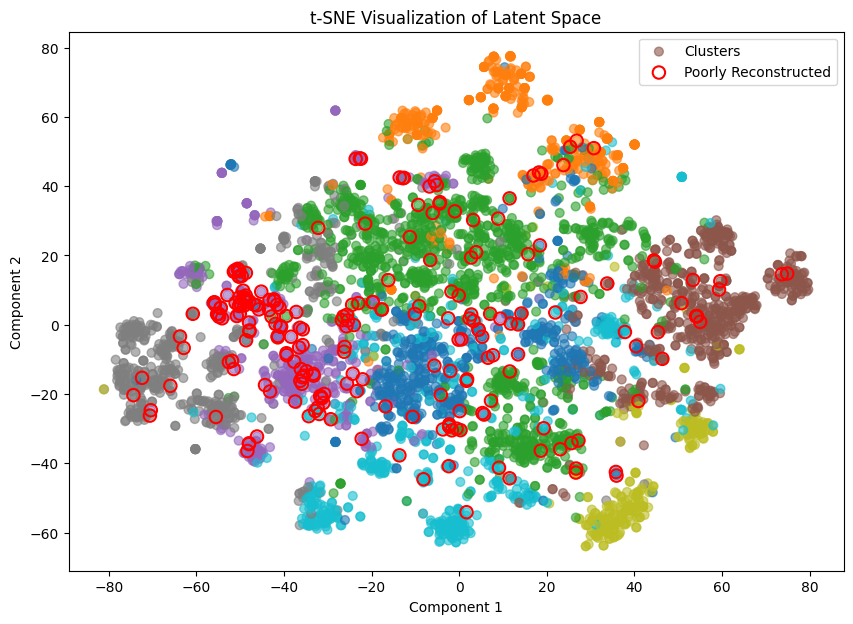

In [132]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE on the reduced (latent) embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(reduced_embeddings)

# Mark outliers
is_outlier = np.zeros(len(df), dtype=bool)
is_outlier[poorly_reconstructed_indices] = True

# Plot with cluster colors and red circles for outliers
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    latent_2d[:, 0],
    latent_2d[:, 1],
    c=df["Cluster"],  # Color by cluster
    cmap='tab10',
    alpha=0.6,
    s=40,
    label="Clusters"
)

# Overlay poorly reconstructed points in red
plt.scatter(
    latent_2d[is_outlier, 0],
    latent_2d[is_outlier, 1],
    edgecolor='red',
    facecolor='none',
    s=80,
    linewidths=1.5,
    label="Poorly Reconstructed"
)

plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


# **Save Embedding Files In Google Drive**

In [120]:
from google.colab import drive
#drive.mount('/content/drive')

np.save("embeddings.npy", embeddings)
np.save("reduced_embeddings.npy", reduced_embeddings)
